## Setup

Some code setup: run these cells, declare victory, and move on.

# CX 4230, Spring 2016 [11]: A cellular automaton for the S-I-R model of infection

In this notebook, you will use a cellular automaton to implement a model of the spread of infection, which we will refer to as the susceptible-infectious-recovered CA (SIR-CA) model.

The slides that accompany this notebook are available here (~ 19 MiB): https://t-square.gatech.edu/access/content/group/gtc-59b8-dc03-5a67-a5f4-88b8e4d5b69a/cx4230-sp16--11-infection-and-diffusion.pdf

In [16]:
import numpy as np
import scipy as sp
import scipy.sparse

In [17]:
import matplotlib.pyplot as plt # Core plotting support
%matplotlib inline

## The phenomenon to be modeled and simulated

Suppose we wish to model the spread of an illness in a population distributed geographically. This illness is non-fatal, meaning a person who has it does not die from it; an ill person eventually recovers. The illness is also contagious, spreading by contact. After a roughly fixed and predictable period of time, an ill person recovers and develops an immunity to the illness, meaning he or she will never suffer from the same illness again.

## Conceptual model

As a first cut, let's try using a cellular automaton (CA) as the conceptual model. We will refer to the specific model we develop as the SIR-CA model, as noted above.

Let the world be a square $n \times n$ grid $G = G(t) \equiv \left(g_{ij}(t)\right)$ of cells that evolve over time, which is discrete and measured in, say, (integer) days.

Every cell of $G$ is a position that is either empty or occupied by a person, who exists in one of three possible states:

1. **Susceptible (S)**: This person has never gotten the illness before. If he or she comes in close contact with a sick person, he or she is at risk of catching the illness.
2. **Infected (I)**: This person has the illness and is contagious.
3. **Recovered (R)**: This person had the illness but has developed the immunity. He or she cannot become sick again.

Let's associate these states with the following integers:

In [18]:
# Possible states:
EMPTY = -1
SUSCEPTIBLE = 0
INFECTED = 1
RECOVERED = 2

On the "zeroth day" ($t = 0$), the world is full of susceptible people and one of them gets sick. This state is our initial condition.

In [19]:
N = 10

# Create an empty world at time t=0
peeps_0 = EMPTY * np.ones ((N+2, N+2), dtype=int)
peeps_0[1:-1, 1:-1] = SUSCEPTIBLE # Fill interior with susceptible people

# Infect someone near the middle
i_mid = int ((N+2) / 2)
peeps_0[i_mid, i_mid] = INFECTED

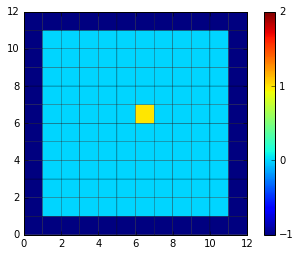

In [20]:
def show_peeps (G, vmin=EMPTY, vmax=RECOVERED, ticks=range (EMPTY, RECOVERED+1)):
    plt.pcolor (G, vmin=vmin, vmax=vmax, edgecolor='black')
    plt.colorbar (ticks=ticks)
    plt.axes().set_aspect('equal')
    
show_peeps (peeps_0)

Let's define some functions to help identify susceptible, infected, and recovered people in this world.

In [21]:
def susceptible (G):
    """
    Given a grid, G, returns a grid S whose (i, j) entry
    equals 1 if G[i, j] is susceptible or 0 otherwise.
    """
    return (G == SUSCEPTIBLE).astype (int)

print (np.sum (susceptible (peeps_0)), "susceptible patient(s) initially")

99 susceptible patient(s) initially


**Exercise.** Complete the following functions, which should find infected and recovered individuals in a given world.

In [22]:
def infected (G):
    """
    Given a grid G, returns a grid I whose (i, j) entry equals 1 if
    G[i, j] is infected or 0 otherwise.
    """
    # @YOUSE
    return ((G >= INFECTED) & (G < RECOVERED)).astype (int)

print (np.sum (infected (peeps_0)), "infected patient(s) initially")

1 infected patient(s) initially


In [23]:
def recovered (G):
    """
    Given a grid G, returns a grid R whose (i, j) entry equals 1 if
    G[i, j] has recovered or 0 otherwise.
    """
    # @YOUSE
    return (G >= RECOVERED).astype (int)

print (np.sum (recovered (peeps_0)), "patient(s) recovered")

0 patient(s) recovered


**Time evolution.** Next, let's define the state evolution rules that determine how the sickness spreads on every subsequent day, $t \geq 1$:

* **R1**) A person is sick for only one day. That is, if he or she is sick on day $t$, then on day $t+1$ he or she will have recovered.
* **R2**) The illness spreads from an infected persons to their north, south, east, and west neighbors, but it does so nondeterministically. More formally, let's call a person at $(i, j)$ _exposed_ if _any_ of her north, south, east, or west neighbors is infected. The _conditional_ probability that any exposed person becomes infected is $\tau$, which is uniform and independent for all positions. Thus, this rule says that all exposed persons will become infected randomly with probability $\tau$.

**Exercise.** To help determine who might catch the disease in a given time step, let's write a function that determines who is exposed. That is, given a grid $G$, this function returns a new grid $E$ such that $e_{ij}$ is `1` if $g_{ij}$ is susceptible and at least one neighbor of $g_{ij}$ is sick, and `0` otherwise.

4 exposed patient(s)


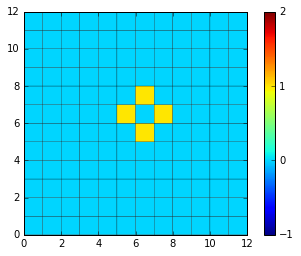

In [24]:
def exposed (G):
    """
    Returns a grid whose (i, j) entry is 1 if it has
    at least 1 infected neighbor, or 0 otherwise.
    """
    # @YOUSE
    I = infected(G)
    E = np.zeros(G.shape,dtype=int) #Exposed people
    E[1:-1, 1:-1] = I[0:-2, 1:-1] | I[1:-1,2:] | I[2:,1:-1] | I[1:-1,0:-2]
    return E

print (np.sum (exposed (peeps_0)), "exposed patient(s)")
show_peeps (exposed (peeps_0))

**Exercise.** Complete the following function. You are given an input grid `G[:,:]` of people and the conditional probability `p` of becoming infected given any sick neighbors. Your function should determine to which grid cells the infection spreads. In particular, it should return a binary (0-1) grid `G_s[:,:]` of the same size as `G[:,:]` where `G_s[i,j]` is `1` with probability `p` if `G[i,j]` is exposed, and `0` otherwise.

Infection spreads to 2 patient(s)


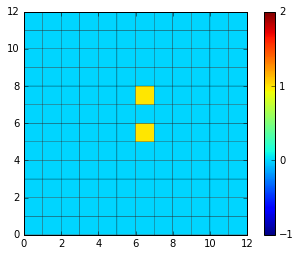

In [25]:
COND_PROB_ILL = 0.5 # Probability of getting sick, given any sick neighbors

def spreads (G, tau=COND_PROB_ILL):
    random_draw = np.random.uniform (size=G.shape)

    # @YOUSE
    G_s = (susceptible(G) * exposed(G) * (random_draw < tau))
    return G_s.astype (int)

np.random.seed (1602034230) # Fixed seed, for debugging
G_s = spreads (peeps_0)
print ("Infection spreads to", np.sum (G_s), "patient(s)")
show_peeps (G_s)

## Putting it all together

The preceding code lays the building blocks for the complete simulation, which the following function implements.

**Exercise.** Write a function to simulate one time-step, given a grid `G[:,:]` and conditional probability `p` of infection when exposed.

In [37]:
def step (G, tau=COND_PROB_ILL):
    """
    Simulates one time step and returns a grid
    of the resulting states.
    """
    # @YOUSE
    return G +infected(G)+spreads(G, tau)

=== BEFORE ===
Total beds: 100
Susceptible: 99
Infected: 1
Recovered: 0

=== AFTER ===
Total beds: 100
Susceptible: 97
Infected: 2
Recovered: 1


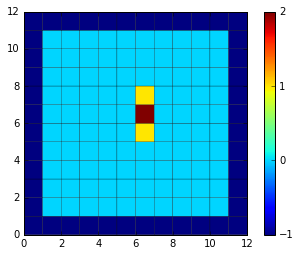

In [38]:
print ("=== BEFORE ===")
summarize (peeps_0)

print ("\n=== AFTER ===")
np.random.seed (1602034230) # Fixed seed, for debugging
peeps_1 = step (peeps_0)
summarize (peeps_1)
show_peeps (peeps_1)

In [39]:
def summarize (G, verbose=True):
    n = (G.shape[0]-2) * (G.shape[1]-2)
    n_s = np.sum (susceptible (G))
    n_i = np.sum (infected (G))
    n_r = np.sum (recovered (G))
    if verbose:
        print ("Total beds:", n)
        print ("Susceptible:", n_s)
        print ("Infected:", n_i)
        print ("Recovered:", n_r)
    return (n_s, n_i, n_r, n)

In [40]:
def sim (G_0, max_steps, tau=COND_PROB_ILL):
    """
    Starting from a given initial state, `G_0`, this
    function simulates up to `max_steps` time steps of
    the S-I-R cellular automaton. It returns a tuple
    `(t, G_t)` containing the final time step
    `t <= max_steps` and simulation state `G_t`.
    """
    t = 0
    G_t = G_0
    (_, num_infected, _, _) = summarize (G_t, verbose=False)
    while (num_infected > 0) and (t < max_steps):
        t = t + 1
        G_t = step (G_t, tau)
        (_, num_infected, _, _) = summarize (G_t, verbose=False)
    return (t, G_t)

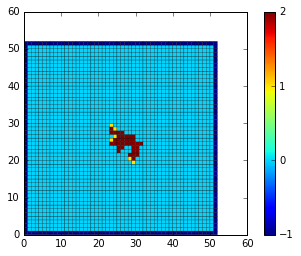

In [41]:
from ipywidgets import interact

def isim (m, n, max_steps=0, tau=COND_PROB_ILL, seed=0):
    np.random.seed (seed)
    
    # Initial state
    G_0 = EMPTY * np.ones ((m+2, n+2), dtype=int)
    G_0[1:-1, 1:-1] = SUSCEPTIBLE
    i_mid = int ((m+2) / 2)
    j_mid = int ((n+2) / 2)
    G_0[i_mid, j_mid] = INFECTED
    
    if not max_steps:
        max_steps = 10 * max (m, n) * (RECOVERED - INFECTED)
    
    (_, G_t) = sim (G_0, max_steps, tau)
    show_peeps (G_t)
    
interact (isim
          , m=(1, 100, 1)
          , n=(1, 100, 1)
          , max_steps=(0, 1000, 10)
          , tau=(0.0, 1.0, 0.01)
          , seed=(0, 100, 1)
         )

**Exercise.** In the simulation as we've set it up, the recovery time is hard-coded at 1 day. Given a different recovery time $k > 1$, how would you modify the simulation?